In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import diff
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import eig

In [233]:
data = np.loadtxt('data.dat') # load data

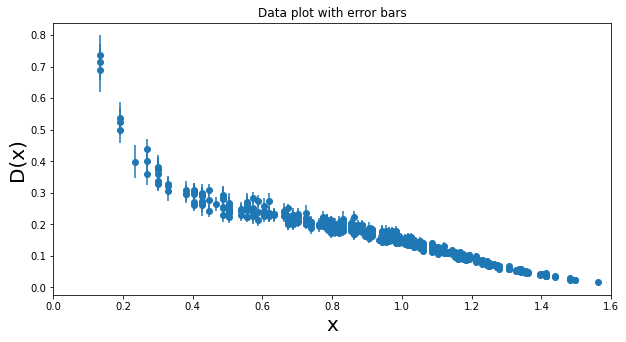

In [234]:
plt.figure(figsize=(10,5))
plt.errorbar(data[:,0], data[:,1], data[:,2], fmt='o')
plt.xlabel("x", fontsize=20)
plt.ylabel("D(x)", fontsize=20)
plt.xlim([0,1.6])
#plt.legend()
plt.title('Data plot with error bars', fontdict=None, loc='center', pad=None)
plt.show()

In [235]:
x = data[:,0]
y_noise = np.log(data[:,1]) # the inference is done on log of the data
y_err = (data[:,2])/data[:,1] # error on log(data)
beta_err = (1/y_err)/np.max(1/y_err) # the known error is trated as a weight on y_noise data
N_tot = x.size # total number of input data 
y_noise=y_noise*beta_err # the data are weighted for the errors

In [236]:
# Computation of LogEvidence for different models (labeled by M_v), in the present case the model is $\sum_{j=0}^M_v w_j*x^(2j)$ (monomia basis function), w_j are the parameters to be inferred
# The definition of the LogEvidence function is in Ref. ....
M_max=21 # Maximum value of M_v for which the LogEvidence function is computed 
log_evidence_vP= np.zeros((M_max))
alpha_vP = np.zeros((M_max)) #initializing \alpha
beta_vP = np.zeros((M_max)) #initializing \beta
g_vP = np.zeros((M_max))
# the LogEvidence function is computed in a semianalytical way (see ...). The integration on the ... is performed analytically.
# In the following the numerical solution for optimal value of \alpha and \beta is found. 
alpha0 = 0.001 #0.001
beta0 = 240 #240
for M_v in range(2,M_max): # M_v: maximum degree of monomia for each models, i.e. number of parameters
    Phi_vP= np.zeros((N, M_v))
    for j in range(0,M_v):
        Phi_vP[:,j]=x**(2*j)*beta_err # monomia basis functions
    li_vP0,ei_vP=eig(np.dot(Phi_vP.T,Phi_vP))
    delta_alphaP = 1
    delta_betaP = 1 
    alphaP = alpha0
    betaP = beta0
    conta = 0
    while abs(delta_alphaP) > 1e-3 or abs(delta_betaP) > 1 and conta < 1e4:
        li_vP=li_vP0*betaP
        SN_vP = np.linalg.inv(alphaP*np.identity(M_v)+betaP*np.dot(Phi_vP.T,Phi_vP))
        mN_vP=betaP*np.dot(np.dot(SN_vP,Phi_vP.T),y_noise) 
        g_vP = np.sum(li_vP.real/(alphaP+li_vP.real)) 
        alpha1P = g_vP/(np.dot(mN_vP.T,mN_vP)) 
        beta1P = 1/(1/(N-g_vP)*np.sum((y_noise-np.dot(Phi_vP,mN_vP.T))**2))
        delta_alphaP = alpha1P-alphaP
        alphaP = alpha1P 
        delta_betaP = beta1P-betaP
        betaP = beta1P
        conta=conta+1
    del conta
    alpha_vP[M_v]=alphaP
    beta_vP[M_v]=betaP
    A_vP=np.linalg.inv(SN_vP) 
    E_mNs_vP=betaP/2*(y_noise-np.dot(Phi_vP,mN_vP.T))**2 
    E_mN_vP=E_mNs_vP.sum()
    log_evidence_vP[M_v]=M_v/2*np.log(alpha_vP[M_v])+N/2*np.log(beta_vP[M_v])-E_mN_vP-1/2*np.log(np.linalg.det(A_vP))-N/2*np.log(2*math.pi)

<ipython-input-236-9d91a207853a>:40: RuntimeWarning: invalid value encountered in log
  log_evidence_vP[M_v]=M_v/2*np.log(alpha_vP[M_v])+N/2*np.log(beta_vP[M_v])-E_mN_vP-1/2*np.log(np.linalg.det(A_vP))-N/2*np.log(2*math.pi)


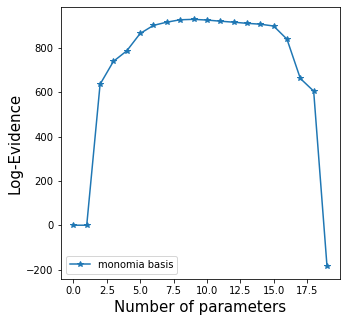

In [237]:
plt.figure(figsize=(5,5))
plt.plot(log_evidence_vP,'-*',label='monomia basis')
plt.xlabel("Number of parameters", fontsize=15)
plt.ylabel("Log-Evidence", fontsize=15)
plt.legend()
plt.show()

In [238]:
M_optP= np.where(log_evidence_vP==max(log_evidence_vP[3:]))[0]
M_optP= M_optP.item()
print('Monomia basis: Optimal number of parameters',M_optP,' - Maximum of the Log-Evidence function',log_evidence_vP[M_optP])

Monomia basis: Optimal number of parameters 9  - Maximum of the Log-Evidence function 928.9054500847183


In [239]:
# Computing the predictive ... (see [])
x_infer = np.linspace(0, 1.6, 50)
# averaging predictive estimation of different models [] (labeled by number of parameters M) in the interval [M_max-L1,M_max+L2], where M_max: max(Evidence)=Evidence(M_max)
# L1 = L2 = 0 --> no averge
L1=0 
L2=0 
meanN_optPj=np.zeros([L1+L2+1,x_infer.size])
sigmaN_optPj=np.zeros([L1+L2+1,x_infer.size]) 
sigma_meanN_optPj=np.zeros([L1+L2+1,x_infer.size])
#
for j_optP in range (M_optP-L1,M_optP+L2+1):
    Phi_inferoptP = np.zeros((x_infer.size, j_optP))
    Phi_optP = np.zeros((x.size, j_optP))
    alpha_optP = alpha_vP[j_optP]
    beta_optP = beta_vP[j_optP] 
    for j in range(0,j_optP):
        Phi_inferoptP[:,j]=x_infer**(2*j)
    for j in range(0,j_optP):
        Phi_optP[:,j]=x**(2*j)*beta_err
    A_optP=alpha_optP*np.identity(j_optP)+beta_optP*np.dot(Phi_optP.T,Phi_optP)
    SN_optP=np.linalg.inv(A_optP)
    sigmaN_optP=1/beta_optP+np.dot(Phi_inferoptP,np.dot(SN_optP,Phi_inferoptP.T))
    sigma_meanN_optP=np.diag(sigmaN_optP)**0.5
    mN_optP=beta_optP*np.dot(np.dot(SN_optP,Phi_optP.T),y_noise)
    meanN_optP=np.dot(Phi_inferoptP,mN_optP.T)
    meanN_optPj[j_optP-M_optP+L1-L2,:]=meanN_optP*(log_evidence_vP[j_optP])
    sigmaN_optPj[j_optP-M_optP+L1-L2,:]=meanN_optP**2*(log_evidence_vP[j_optP])
    sigma_meanN_optPj[j_optP-M_optP+L1-L2,:]=sigma_meanN_optP
meanN_optPtot=np.sum(meanN_optPj,axis=0)/np.sum((log_evidence_vP[M_optP-L1:M_optP+L2+1])) # predictive estimation 
sigmaN_optPtot=np.sum(sigmaN_optPj,axis=0)/np.sum((log_evidence_vP[M_optP-L1:M_optP+L2+1]))-meanN_optPtot**2 # error on the predictive estimation

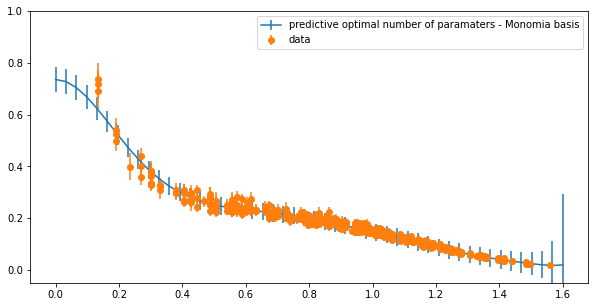

In [240]:
plt.figure(figsize=(10,5))
plt.errorbar(x_infer,np.exp(meanN_optPtot),np.sqrt(np.abs(sigmaN_optPtot))+np.sum(sigma_meanN_optPj,axis = 0),label='predictive optimal number of paramaters - Monomia basis')
plt.errorbar(data[:,0],data[:,1],data[:,2], fmt='o',label='data')
plt.ylim([-0.05, 1])
plt.legend()
plt.show()

In [241]:
# Computing the LogEvidence function as a function of the number of input data taken progressively under account
log_evidence_vP = np.zeros((M_max))
alpha_vP = np.zeros((M_max))
beta_vP = np.zeros((M_max))
g_vP = np.zeros((M_max))
M_optP = np.zeros((N_tot))
log_evidenceP = np.zeros((N_tot))
alphaP_Nv = np.zeros((N_tot))
betaP_Nv = np.zeros((N_tot))
N_min=10 # minimum number of input data for which the LogEvidence is computed
for N_v in range(N_min,N_tot):
    y_noise = np.log(data[:N_v,1])
    x = data[:N_v,0]
    y_err = data[:N_v,2]/data[:N_v,1]
    beta_err = (1/y_err)/np.max(1/y_err)
    y_noise = y_noise*beta_err 
    alpha0 = 0.001 # initializing \alpha
    beta0 = 240 # initializing \beta
    for M_v in range(2,M_tot): # number of parameters
        Phi_vP= np.zeros((N_v, M_v))
        for j in range(0,M_v):
            Phi_vP[:,j]=x**(2*j)*beta_err
        li0_vP,ei_vP=eig(np.dot(Phi_vP.T,Phi_vP))
        delta_alphaP = 1
        delta_betaP = 1 
        alphaP = alpha0
        betaP = beta0
        conta = 0 
        while abs(delta_alphaP) > 1e-3 or abs(delta_betaP) > 1 and conta < 1e4:
            li_vP=li0_vP*betaP
            SN_vP = np.linalg.inv(alphaP*np.identity(M_v)+betaP*np.dot(Phi_vP.T,Phi_vP))
            mN_vP=betaP*np.dot(np.dot(SN_vP,Phi_vP.T),y_noise) 
            g_vP = np.sum(li_vP.real/(alphaP+li_vP.real)) 
            alpha1P = g_vP/(np.dot(mN_vP.T,mN_vP)) 
            beta1P = 1/(1/(N_v-g_vP)*np.sum((y_noise-np.dot(Phi_vP,mN_vP.T))**2))
            delta_alphaP = alpha1P-alphaP
            alphaP = alpha1P 
            delta_betaP = beta1P-betaP
            betaP = beta1P
            conta = conta +1
        alpha_vP[M_v]=alphaP
        beta_vP[M_v]=betaP
        A_vP=np.linalg.inv(SN_vP) 
        E_mNs_vP=betaP/2*(y_noise-np.dot(Phi_vP,mN_vP.T))**2 
        E_mN_vP=E_mNs_vP.sum()
        log_evidence_vP[M_v]=M_v/2*np.log(alpha_vP[M_v])+N_v/2*np.log(beta_vP[M_v])-E_mN_vP-1/2*np.log(np.linalg.det(A_vP))-N_v/2*np.log(2*math.pi)
    M_optPv = np.where(log_evidence_vP==max(log_evidence_vP))[0] # optimal number of parameters (estimated by the maximum of the LogEvidence function for each number of input data)
    M_optP[N_v] = M_optPv.item()
    log_evidenceP[N_v] = log_evidence_vP[M_optPv] # LogEvidence as a function of the number of input data progressively taken under account for the optimal number of parameters (for which the LogEvidence function is maximum at a given number of input data)
    alphaP_Nv[N_v] = alpha_vP[M_optPv] # optimal alpha as a function of the number of input data progressively taken under account
    betaP_Nv[N_v] = beta_vP[M_optPv] # optimal beta as a function of the number of input data progressively taken under consideration

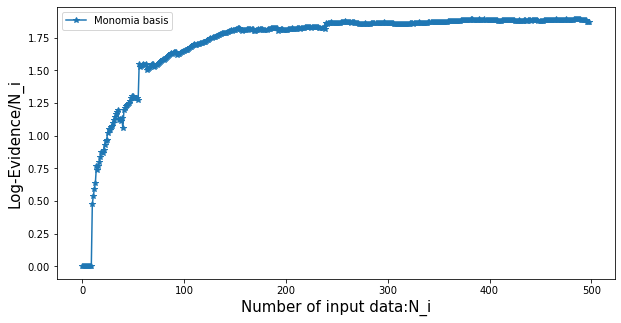

In [247]:
# Plotting the LogEvidence function/number of input data as a function of the number of input data 
plt.figure(figsize=(10,5))
plt.plot(log_evidenceP/np.linspace(1, N_tot, N_tot),'-*',label='Monomia basis')
plt.xlabel("Number of input data:N_i", fontsize=15)
plt.ylabel("Log-Evidence/N_i", fontsize=15)
plt.legend()
plt.show()

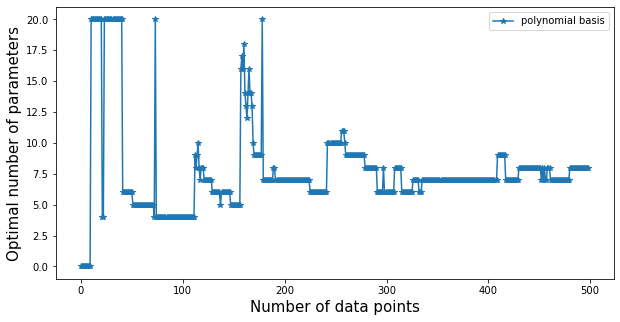

In [243]:
# Plotting the optimal number of parameters as a function of the number of input data
plt.figure(figsize=(10,5))
plt.plot(M_optP,'-*',label='Monomia basis')
plt.xlabel("Number of input data:N_i", fontsize=15)
plt.ylabel("Optimal number of parameters", fontsize=15)
plt.legend()
plt.show()

In [250]:
# Computing the value at x=0 from the predictive ... as a function of the number of input data taken under account
x_infer0 = np.linspace(0, 1, 2)
datax0 = np.zeros((N_tot))
err_datax0 = np.zeros((N_tot))
for N_v in range(10,N_tot):
    y_noise = np.log(data[:N_v,1])
    y_err = np.abs(np.log(data[:N_v,2]))
    beta_err = (1/y_err)
    y_noise = y_noise*beta_err
    x = data[:N_v,0]
    M_optP0 = np.int(M_optP[N_v])
    Phi_inferoptP0 = np.zeros((x_infer0.size, M_optP0))
    Phi_optP0 = np.zeros((x.size, M_optP0))
    alpha_optP0 = alphaP_Nv[N_v]
    beta_optP0 = betaP_Nv[N_v] 
    for j in range(0,M_optP0):
        Phi_inferoptP0[:,j] = x_infer0**(2*j)
    for j in range(0,M_optP0):
        Phi_optP0[:,j] = x**(2*j)*beta_err
    A_optP0 = alpha_optP0*np.identity(M_optP0)+beta_optP0*np.dot(Phi_optP0.T,Phi_optP0)
    SN_optP0 = np.linalg.inv(A_optP0)
    sigmaN_optP0 = 1/beta_optP0+np.dot(Phi_inferoptP0,np.dot(SN_optP0,Phi_inferoptP0.T))
    sigma_meanN_optP0 = np.diag(sigmaN_optP0)**0.5
    mN_optP0 = beta_optP0*np.dot(np.dot(SN_optP0,Phi_optP0.T),y_noise)
    meanN_optP0 = np.dot(Phi_inferoptP0,mN_optP0.T)
    datax0[N_v] = np.exp(meanN_optP0[0]) # predictive value of data at x=0 as a function of the number of parameters progressively taken under account
    err_datax0[N_v] = sigma_meanN_optP0[0] # error on the predictive value of data at x=0 as a function of the number of parameters progressively taken under account

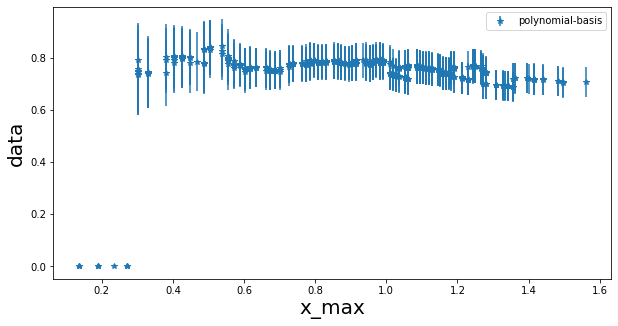

In [252]:
# Plotting the predictive value of data at x=0 as a function of the number of input data
xplot = data[:,0]
plt.figure(figsize=(10,5))
plt.errorbar(xplot,datax0,err_datax0,fmt='*',label='polynomial-basis')
plt.ylabel("data", fontsize=20)
plt.xlabel("x_max", fontsize=20)
plt.legend()
plt.show()